### Load Risk Prediction ML Pipeline

### Import packages

In [1]:
import os
import sys
import numpy as np

sys.path.append(os.path.abspath(os.path.join('../')))
os.chdir('../')

In [2]:
from src.utils.data_extractor import DataExtractor
from src.utils.eda_analyzer import EDAAnalyzer
from src.utils.data_validator import DataValidator

from src.utils.data_preprocessor import DataPreprocessor
from src.utils.model_trainer import LightGBMAutoML

from src.utils.utils import merge_data
import pandas as pd


### Step 1: Data Extraction

In [3]:
loan_filepath = "data/loan.csv"
payment_filepath = 'data/payment.csv'
underwriting_filepath = 'data/clarity_underwriting_variables.csv'

loan_df = DataExtractor.extract_csv(file_path=loan_filepath)
payment_df = DataExtractor.extract_csv(file_path=payment_filepath)
underwriting_df = DataExtractor.extract_csv(file_path=underwriting_filepath)

2024-09-19 11:03:32,459 - INFO - Extracted data from CSV file: data/loan.csv
2024-09-19 11:03:33,081 - INFO - Extracted data from CSV file: data/payment.csv
/home/babi/jobs/moneylion/m/Loan-Risk-Prediction-Pipeline/src/utils/data_extractor.py:23: DtypeWarning: Columns (9,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,31,32,33,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, **kwargs)
2024-09-19 11:03:33,344 - INFO - Extracted data from CSV file: data/clarity_underwriting_variables.csv


### Step 2: Data Validation

In [4]:
# Initialize DataValidator
validator = DataValidator()

# Generate or update schema for each DataFrame
validator._validate_against_schema(loan_df, schema_name="loan_schema")
validator._validate_against_schema(payment_df, schema_name="payment_schema")
validator._validate_against_schema(underwriting_df, schema_name="underwriting_schema")


2024-09-19 11:03:33,355 - INFO - Data schema validation passed.
2024-09-19 11:03:33,358 - INFO - Data schema validation passed.
2024-09-19 11:03:33,364 - INFO - Data schema validation passed.


True

### Step 3: Data Pre-Processing

In [5]:
merged_df = merge_data(loan_df, payment_df, underwriting_df)

In [6]:
pre_processor = DataPreprocessor(merged_df)


replacements = [
    {
        'column': 'clearfraudscore',
        'from': np.nan,
        'to': 0
    },
     {
        'column': 'totalnumberoffraudindicators',
        'from': np.nan,
        'to': 0
    },
       {
        'column': 'thirtydaysago',
        'from': np.nan,
        'to': 0
    },
    
    {
        'column': 'overallmatchresult',
        'from': np.nan,
        'to': 'unknown'
    },
    
    {
        'column': 'fpStatus',
        'from': np.nan,
        'to': 'NoAchAttempt'
    },
    {
        'column': 'nPaidOff',
        'from': np.nan,
        'to': 0
    }  
    ]


X_train, X_test, y_train, y_test =  (
    pre_processor
    .drop_rows_with_nulls_in_columns(columns=['loanId', 'apr', 'loanAmount', 'payFrequency', 'loanStatus'])
    .replace_values(replacements)
     .drop_columns(columns=[
         'loanId', 'clarityFraudId', 'applicationDate', 'originatedDate', 'paymentDate',
         'phonematchresult', 'ssnnamematch', 'nameaddressmatch', 'overallmatchresult', 'ssndobmatch',
         'principal', 'installmentIndex', 'state'])
    .drop_highly_correlated()
    .drop_duplicates()
    .save_or_load_categories(categorical_columns=['loanStatus', 'leadType', 'fpStatus', 'payFrequency', 'anon_ssn'])
    .split_data(target_column="loanStatus")
)


2024-09-19 11:03:35,346 - INFO - Dropped rows with null values in column loanId. Before: (577682, 36), After: (577426, 36)
2024-09-19 11:03:35,621 - INFO - Dropped rows with null values in column apr. Before: (577426, 36), After: (573760, 36)
2024-09-19 11:03:35,857 - INFO - Dropped rows with null values in column loanAmount. Before: (573760, 36), After: (573731, 36)
2024-09-19 11:03:36,051 - INFO - Dropped rows with null values in column payFrequency. Before: (573731, 36), After: (572512, 36)
2024-09-19 11:03:36,295 - INFO - Dropped rows with null values in column loanStatus. Before: (572512, 36), After: (572377, 36)
2024-09-19 11:03:36,296 - INFO - Final shape after dropping rows with null values in columns: ['loanId', 'apr', 'loanAmount', 'payFrequency', 'loanStatus']. Initial shape: (577682, 36), Final shape: (572377, 36)
2024-09-19 11:03:36,301 - INFO - Replaced nan with 0 in column: clearfraudscore
2024-09-19 11:03:36,305 - INFO - Replaced nan with 0 in column: totalnumberoffraud

In [7]:
X_test.head(1).to_dict(orient='records')

[{'anon_ssn': 'dc3b9f161faae5553f778eca7fc6787f',
  'payFrequency': 'B',
  'apr': 590.0,
  'originated': False,
  'nPaidOff': 0.0,
  'loanAmount': 500.0,
  'leadType': 'bvMandatory',
  'leadCost': 6,
  'fpStatus': 'NoAchAttempt',
  'hasCF': 1,
  'clearfraudscore': 0.0,
  'thirtydaysago': 0.0,
  'totalnumberoffraudindicators': 0.0,
  'loan_age': -1.0}]

### Step 3: Model Training

In [8]:
light_gbm = LightGBMAutoML(X_train, X_test, y_train, y_test)

2024-09-19 11:03:43,305 - INFO - Model version determined: 1.0.5


dir: /home/babi/jobs/moneylion/m/Loan-Risk-Prediction-Pipeline


In [12]:
light_gbm.train_model()

2024-09-19 11:03:43,314 - INFO - Starting AutoML training for multi-class classification...


[flaml.automl.logger: 09-19 11:03:44] {1680} INFO - task = classification
[flaml.automl.logger: 09-19 11:03:44] {1691} INFO - Evaluation method: holdout


2024-09-19 11:03:47,700 - INFO - class 1 augmented from 1 to 20
2024-09-19 11:03:48,466 - INFO - class 9 augmented from 4 to 20
2024-09-19 11:03:49,471 - INFO - class 10 augmented from 3 to 21
2024-09-19 11:03:50,086 - INFO - class 12 augmented from 4 to 20


[flaml.automl.logger: 09-19 11:03:50] {1789} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 09-19 11:03:50] {1901} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl.logger: 09-19 11:03:50] {2219} INFO - iteration 0, current learner lgbm


2024/09/19 11:04:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: list index out of range


[flaml.automl.logger: 09-19 11:05:42] {2345} INFO - Estimated sufficient time budget=45159317s. Estimated necessary time budget=45159s.
[flaml.automl.logger: 09-19 11:05:43] {2392} INFO -  at 119.5s,	estimator lgbm's best error=0.2249,	best estimator lgbm's best error=0.2249
[flaml.automl.logger: 09-19 11:05:43] {2219} INFO - iteration 1, current learner lgbm


2024/09/19 11:06:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: list index out of range


#### Evaluate the model

In [13]:
light_gbm.evaluate_model()

/home/babi/miniconda3/envs/moneylion/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/babi/miniconda3/envs/moneylion/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/babi/miniconda3/envs/moneylion/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

(0.8377784750549105,
 '                             precision    recall  f1-score   support\n\n        CSR Voided New Loan       0.00      0.00      0.00       217\n       Charged Off Paid Off       0.00      0.00      0.00        40\n         Credit Return Void       0.28      0.06      0.09       125\n   Customer Voided New Loan       0.00      0.00      0.00        94\n  Customver Voided New Loan       0.00      0.00      0.00         1\n        External Collection       0.63      0.21      0.31      2292\n        Internal Collection       0.00      0.00      0.00      1153\n                   New Loan       0.52      0.38      0.43      1632\n              Paid Off Loan       0.53      0.09      0.15      2268\n    Pending Application Fee       0.00      0.00      0.00         2\n           Pending Paid Off       0.00      0.00      0.00        30\n                   Rejected       0.92      0.37      0.52     16787\n              Returned Item       0.00      0.00      0.00       

### Model Evaluation Summary

#### 1. **Accuracy**
- The model achieved an overall accuracy of **83.91%**, meaning it correctly predicted 84% of the test data.

#### 2. **Class-Level Performance**
- Many smaller classes (e.g., **CSR Voided New Loan, Charged Off Paid Off**) had **0.00 precision, recall, and F1-scores**, indicating the model struggled to predict them, likely due to class imbalance.
- **Credit Return Void**: High recall (0.99) but moderate precision (0.48), indicating the model correctly identifies most instances but includes some incorrect predictions.
- **Rejected**: High precision (0.92) but low recall (0.37), meaning the model correctly predicts this class but misses many actual instances.
- **Withdrawn Application**: Strong performance with **precision (0.85)** and **recall (0.99)**, indicating the model handles this class well.

#### 3. **Averages**
- **Macro average** (unweighted) shows low performance across classes, with an F1-score of **0.16**.
- **Weighted average** (considering class sizes) is much better, with an F1-score of **0.80**, indicating strong performance for dominant classes but poor performance for minority classes.

#### 4. **Conclusion**
The model performs well for large classes but struggles with smaller, underrepresented ones. Addressing class imbalance via resampling or class weighting could improve results.

#### Plot feature importance

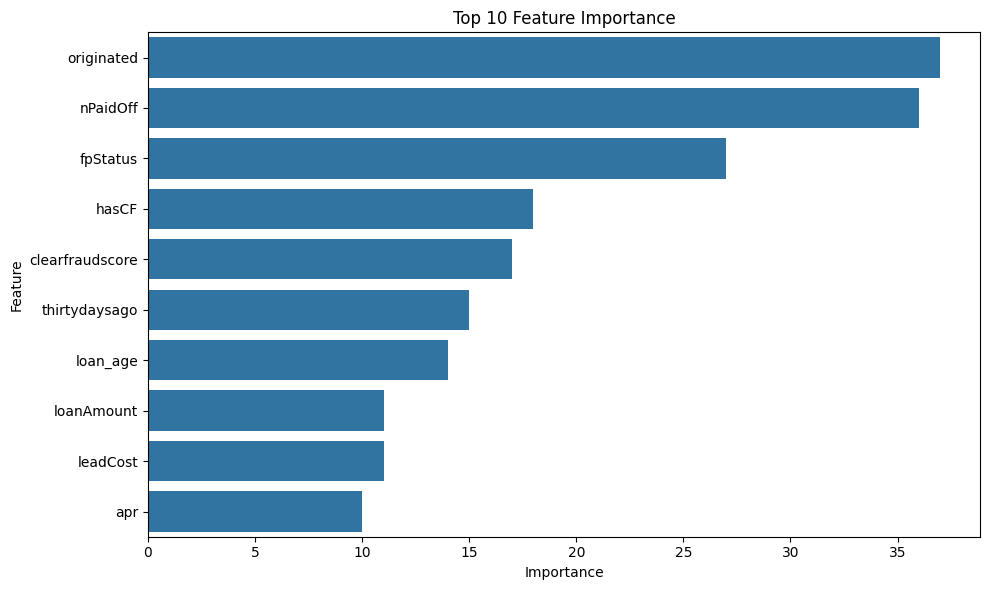

In [14]:
light_gbm.plot_feature_importance()

#### Plot training metrics

In [16]:
model = light_gbm.model.model

In [17]:
import lightgbm as lgb


<Figure size 2000x1000 with 0 Axes>

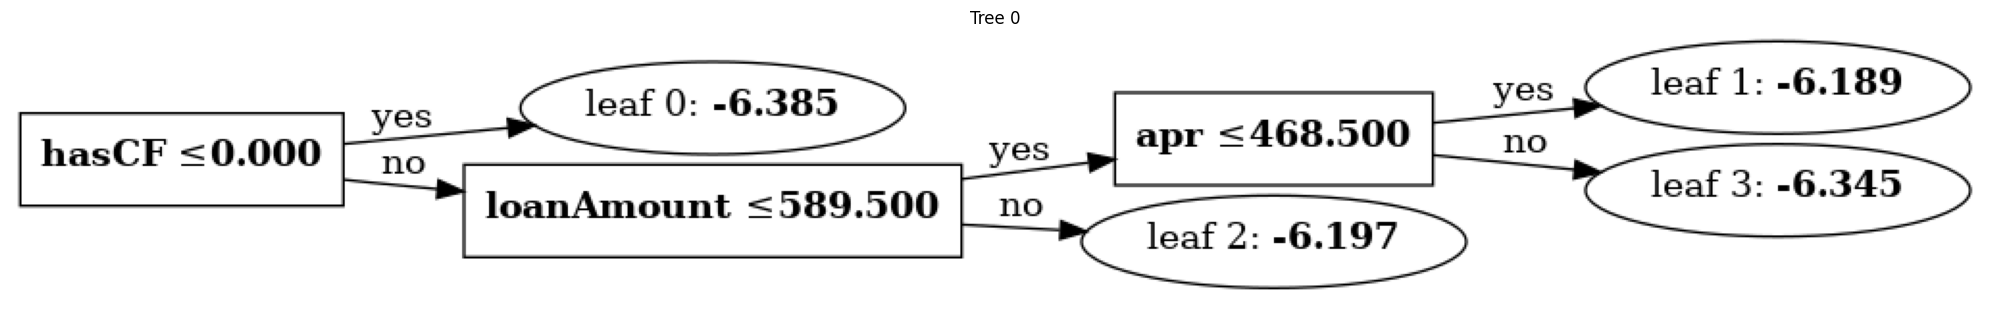

In [18]:
light_gbm.plot_trees(tree_index=0)

<Figure size 2000x1000 with 0 Axes>

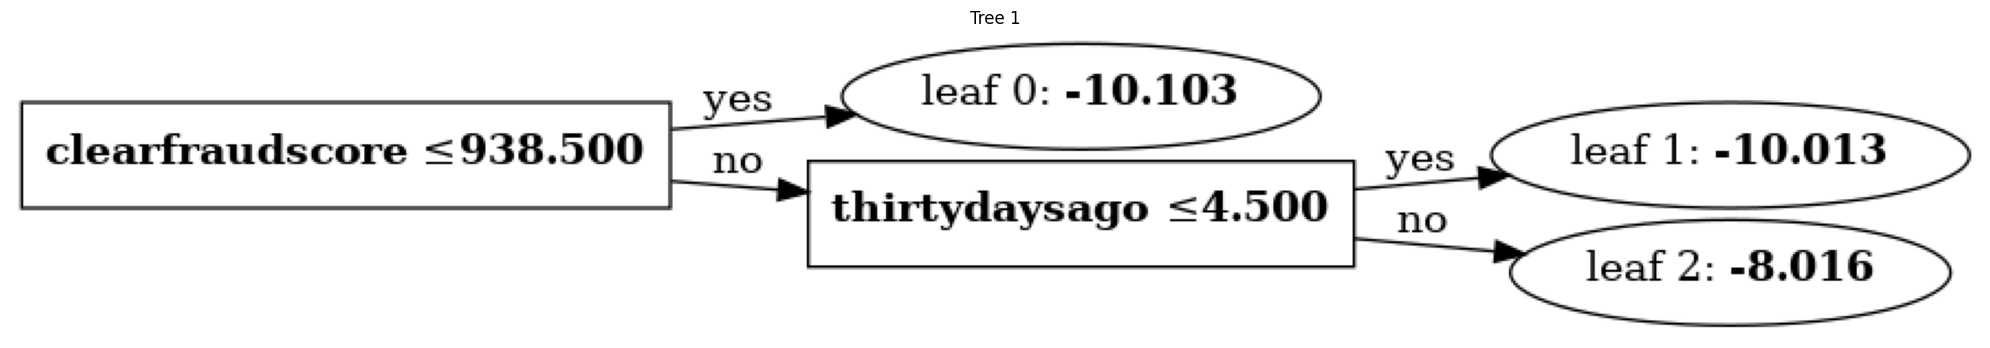

In [19]:
light_gbm.plot_trees(tree_index=1)

In [20]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

import lightgbm as lgb

try:
    from ipywidgets import interact

    INTERACTIVE = True
except ImportError:
    INTERACTIVE = False
    
def render_histogram(feature):
    lgb.plot_split_value_histogram(model, feature=feature, bins="auto", figsize=(10, 5))
    plt.show()


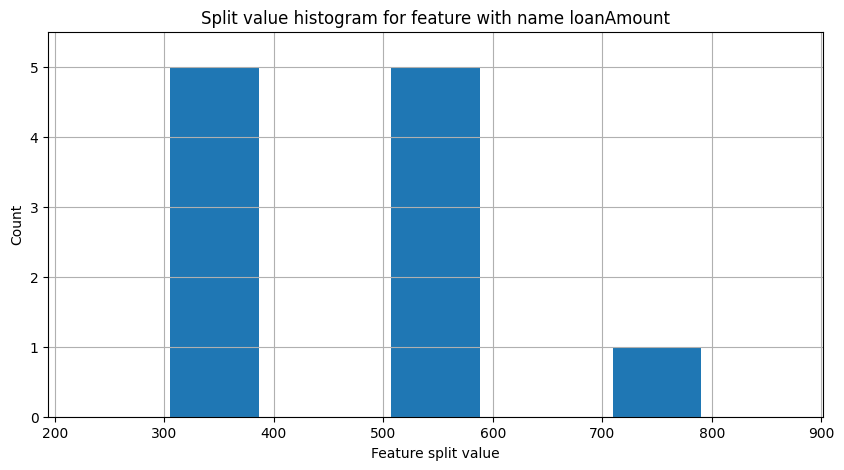

In [21]:
if INTERACTIVE:
    interact(render_histogram, feature=model.feature_name_)
else:
    render_histogram(feature="loanAmount")

In [24]:
light_gbm.automl

AutoML(append_log=False, auto_augment=True, custom_hp={},
       cv_score_agg_func=None, early_stop=False, ensemble=False,
       estimator_list='auto', eval_method='auto', fit_kwargs_by_estimator={},
       force_cancel=False, free_mem_ratio=0, hpo_method='auto',
       keep_search_state=False, learner_selector='sample', log_file_name='',
       log_training_metric=False, log_type='better', max_iter=None,
       mem_thres=4294967296, metric='auto', metric_constraints=[],
       min_sample_size=10000, mlflow_logging=True, model_history=False,
       n_concurrent_trials=1, n_jobs=-1, n_splits=5, pred_time_limit=inf,
       preserve_checkpoint=True, retrain_full=True, ...)

In [25]:
lgb_classifer = light_gbm.automl.model.model
lgb_classifer

LGBMClassifier(learning_rate=0.09999999999999995, max_bin=255, n_estimators=1,
               n_jobs=-1, num_leaves=4, reg_alpha=0.0009765625, reg_lambda=1.0,
               verbose=-1)

In [26]:
lgb_classifer.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.09999999999999995,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 1,
 'n_jobs': -1,
 'num_leaves': 4,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0009765625,
 'reg_lambda': 1.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'max_bin': 255,
 'verbose': -1}